# Home Assignment 1
## Group 3
- Diogo Araújo, fcXXXXX  - (?)H
- João Braz, fc60419     - (?)H
- Joel Oliveira, fc59442 - 8 H

In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from scipy.sparse import dok_matrix
from scipy.sparse.linalg import svds

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, max_error, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef

np.seterr(divide='ignore', invalid='ignore');

In [2]:
# Merge the two datasets
df = pd.read_csv("train.csv").merge(
    pd.read_csv("unique_m.csv"), 
    left_index=True, 
    right_index=True
)
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp_y,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [3]:
# Separate dependent and independent sets
X = df.drop(columns=["critical_temp_x", "critical_temp_y", "material"])
y = df.critical_temp_x

In [4]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

In [79]:
X_train.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
2915,5,95.891840,54.218519,73.468530,35.684328,1.417888,1.571195,158.96740,7.961206,55.618703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3532,5,68.975310,52.166945,54.601832,35.695649,1.417052,1.298332,121.32760,21.642785,41.946967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4002,5,38.834940,35.215547,35.512542,31.782735,1.530118,1.401505,47.54660,10.319767,15.133740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
10044,1,112.411000,112.411000,112.411000,112.411000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3553,5,88.936744,52.703157,70.358975,35.893190,1.445824,1.351537,122.90607,20.662714,46.482335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


## Objective 1 - Dimensionality reduction

In [20]:
print(f"Percentage of 0's in the X matrix = {(X_train==0).sum().sum() / np.prod(X_train.shape):.3f}")

Percentage of 0's in the X matrix = 0.495


Roughly half of the data contains non-null elements. <br>
We will use PCA for the dimensionality reduction, as the majority of the matrix is dense.

In [21]:
#create a scaler to compare data with and without scaling
scaler = StandardScaler().fit(X_train)

In [24]:
n_elements_pca = len(PCA(n_components=0.9, svd_solver='full').fit(X_train).explained_variance_)
n_scaled_elements_pca = len(PCA(n_components=0.9, svd_solver='full').fit(
    scaler.transform(X_train)
).explained_variance_)

print(f"Number of components to reach 90% explainability with non-scaled dataset = {n_elements_pca}")
print(f"Number of components to reach 90% explainability with scaled dataset = {n_scaled_elements_pca}")

Number of components to reach 90% explainability with non-scaled dataset = 2
Number of components to reach 90% explainability with scaled dataset = 66


Both scenarios have a good decrease in the number of features. Originally there were 170.

In [70]:
#function to scatter in pre-defined axis
def scatter(x, y, c, ax, xlabel="", ylabel="", title="", cmap="seismic"):
    ax.scatter(x,y,c=c, cmap=cmap, s=3)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


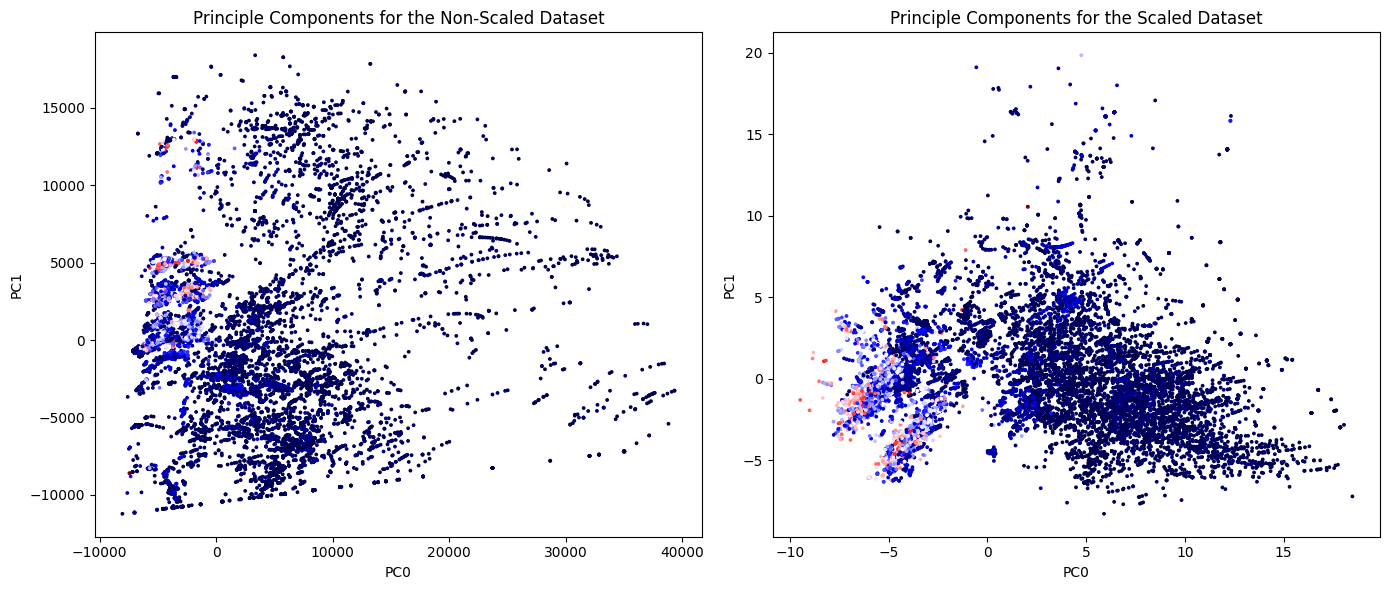

In [74]:
f, ax = plt.subplots(1,2, figsize=(14,6))

X_train_reduced = PCA(n_components=0.9, svd_solver='full').fit_transform(X_train)
X_train_scaled_reduced = PCA(n_components=0.9, svd_solver='full').fit_transform(
    scaler.transform(X_train)
)

scatter(X_train_reduced[:,0], X_train_reduced[:, 1], y_train, ax[0], "PC0", "PC1", "Principle Components for the Non-Scaled Dataset")
scatter(X_train_scaled_reduced[:,0], X_train_scaled_reduced[:, 1], y_train, ax[1], "PC0", "PC1", "Principle Components for the Scaled Dataset")

f.tight_layout()

From the figure above, it seems that even though the original dataset has only 2 components to explain all the variance, the scaled dataset clusters the data better with it's 2 main components. 

Text(0.5, 1.0, 'Correlation heatmap of the Principal Components')

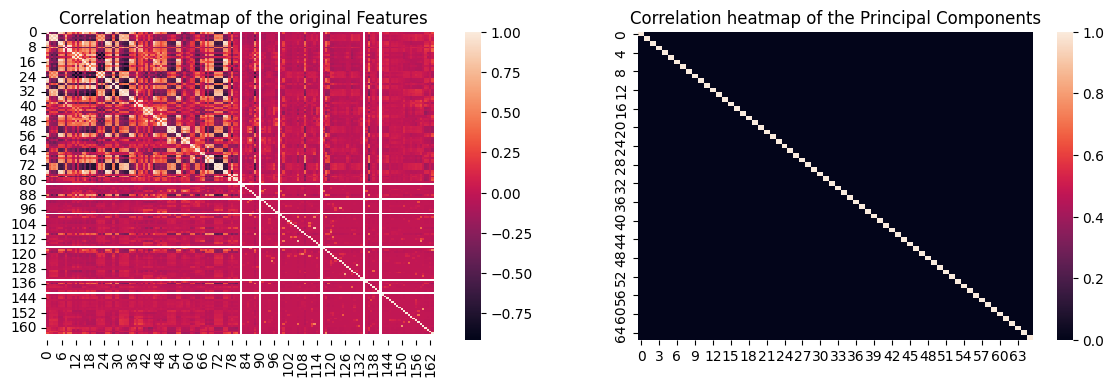

In [123]:
f, ax = plt.subplots(1,2, figsize=(14,4))

sns.heatmap(
    np.corrcoef(scaler.transform(X_train).T), 
    ax=ax[0]
)
ax[0].set_title("Correlation heatmap of the original Features")
sns.heatmap(
    np.corrcoef(
        PCA(n_components=0.9, svd_solver="full").fit_transform(
            scaler.transform(X_train)
        ).T
    ), 
    ax=ax[1]
)
ax[1].set_title("Correlation heatmap of the Principal Components");


In the left plot we can see that in the full dataset there are some features that are redundant. Overall it seems that some independent variables are related to other independent variables.<br>
On the plot presented on the right, as expected, we can see that the components are not correlated with each other. 

## Objective 2 - Create a Regression and a Classification Model

### 2.1 Regression Model

For this section we will use Decision Tree, as PCA components are decorrelated between themselves. With no linear relation between components we do not expect Linear Regression to have a good performance.

In [89]:
t =time()
dtr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", DecisionTreeRegressor())
]).fit(X_train, y_train)
print(f"Train time without PCA = {time() - t:.3f}")

t = time()
dtr_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("regressor", DecisionTreeRegressor())
]).fit(X_train, y_train)
print(f"Train time with PCA = {time() - t:.3f}")


Fit time without PCA = 1.877
Fit time with PCA = 1.939


We can see that PCA didn't create much overhead. The complexity is mainly in training the tree model.

In [104]:
def scatter(y_test, preds, ax, ylabel="True Values", xlabel="Predicted Values", title=""):
    ax.scatter(preds,y_test, s=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.plot([0,140],[0,140], "r")
    ax.grid()

Prediction time without PCA = 0.008
Prediction time with PCA = 0.011
------------------------------------------------------------------------------------------------------------------------
Full Dataset RMSE = 12.799 					 | Reduced Dataset RMSE = 12.836
Full Dataset Max. Error = 119.620 				 | Reduced Dataset Max. Error = 111.000
Full Dataset Pearson Corr. = 0.928 				 | Reduced Dataset Pearson Corr = 0.928


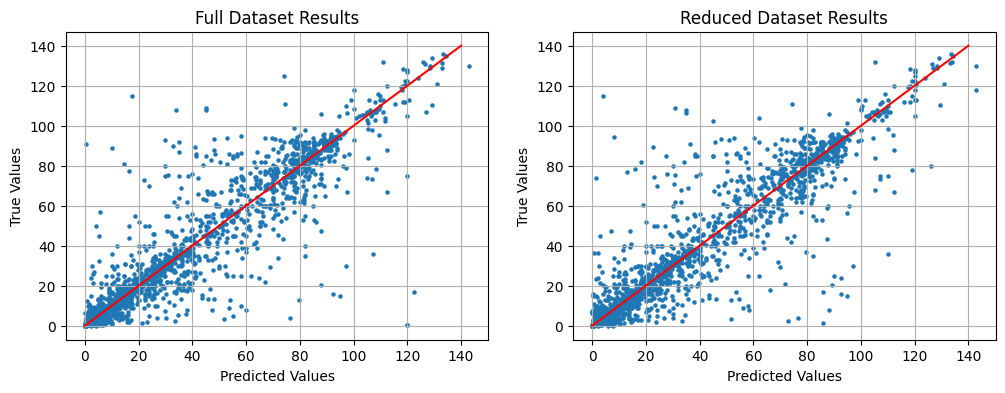

In [109]:
t = time()
preds = dtr.predict(X_test)
print(f"Prediction time without PCA = {time() - t:.3f}")
t=time()
preds_pca = dtr_pca.predict(X_test)
print(f"Prediction time with PCA = {time() - t:.3f}", end="\n"+"-"*120+"\n")
#Compute RMSE
rmse = mean_squared_error(y_test, preds, squared=False)
rmse_pca = mean_squared_error(y_test, preds_pca, squared=False)
#Compute Maximum Error
max_err = max_error(y_test, preds)
max_err_pca = max_error(y_test, preds_pca)
#Compute Pearson Correlation between predictions and original data
pearson_r = np.corrcoef(y_test, preds)[0,1]
pearson_r_pca = np.corrcoef(y_test, preds_pca)[0,1]

print(f"Full Dataset RMSE = {rmse:.3f}", "\t"*5,  f"| Reduced Dataset RMSE = {rmse_pca:.3f}")
print(f"Full Dataset Max. Error = {max_err:.3f}", "\t"*4, f"| Reduced Dataset Max. Error = {max_err_pca:.3f}")
print(f"Full Dataset Pearson Corr. = {pearson_r:.3f}", "\t"*4, f"| Reduced Dataset Pearson Corr = {pearson_r_pca:.3f}")
f, ax = plt.subplots(1,2,figsize=(12,4))

scatter(y_test, preds, ax[0], title="Full Dataset Results")
scatter(y_test, preds_pca, ax[1],title="Reduced Dataset Results")

In [114]:
print(
    "Full dataset number of elements = ", 
    np.prod(X_train.shape),
    "\nReduced dataset number of elements = ",
    np.prod(
        PCA(n_components=0.9, svd_solver="full").fit_transform(
            StandardScaler().fit_transform(X_train)
        ).shape
    ),
)

Full dataset number of elements =  3195712 
Reduced dataset number of elements =  1262976


We can see that the regression difference is minimal using full dataset or reduced dataset. In fact, while the RMSE stayed almost the same, the maximum error obtained in the reduced dataset is reduced. <br>

There is almost no overhead in the prediction time, using PCA. <br>

With this results, it is much better to use the reduced dataset, as the total size is reduced from $3195712$ elements to $1262976$, which is around $2.5$ less space.

### 2.2 Classification Model

It is requested to use both NaiveBayes and DecisionTrees for Full Dataset and the Reduced Dataset. <br>
First we will compare the models on the full dataset. Afterwards compare both models using the reduced dataset.

In [117]:
def to_class(x: float) -> str:
    if 0 <= x < 1.0:
        return "VeryLow"
    elif 1 <= x < 5.0:
        return "Low"
    elif 5 <= x < 20.0:
        return "Medium"
    elif 20 <= x < 100.0:
        return "High"
    elif x >= 100:
        return "VeryHigh"
    return np.nan


y_train_class = y_train.apply(to_class)
y_test_class = y_test.apply(to_class)

- Full Dataset 

In [137]:
t = time()
dtc = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
print(f"Decision Tree train time (no PCA) = {time() - t:.3f}")

t = time()
nb = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", GaussianNB())
]).fit(X_train, y_train_class)
print(f"Naive Bayes train time (no PCA) = {time() - t:.3f}")

Decision Tree train time (no PCA) = 2.595
Naive Bayes train time (no PCA) = 0.192


For this small dataset, we can already see big differences in the training time of Naive Bayes model and Decision Trees.

Decision Tree predict time (no PCA) = 0.013
Naive Bayes predict time (no PCA) = 0.033
Decision Tree MFCC = 0.770 					 | Naive Bayes MFCC = 0.243


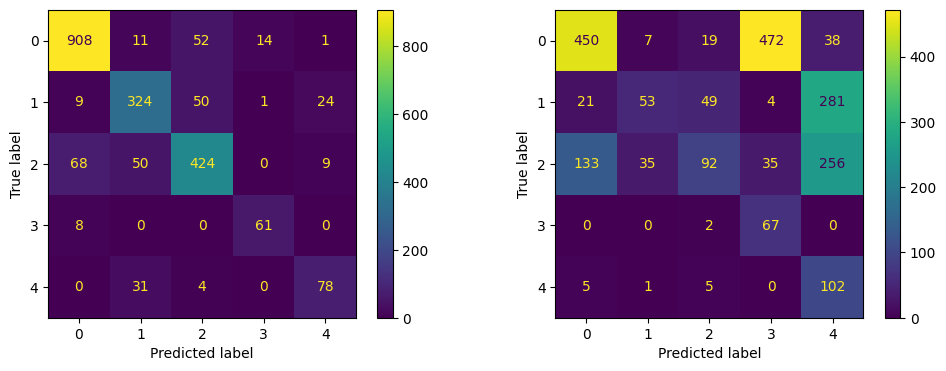

In [138]:
t = time()
dtc_preds = dtc.predict(X_test)
print(f"Decision Tree predict time (no PCA) = {time() - t:.3f}")
t=time()
nb_preds = nb.predict(X_test)
print(f"Naive Bayes predict time (no PCA) = {time() - t:.3f}")

#Compute MFCC
dtc_mfcc = matthews_corrcoef(y_test_class,dtc_preds)
nb_mfcc= matthews_corrcoef(y_test_class, nb_preds)

print(f"Decision Tree MFCC = {dtc_mfcc:.3f}", "\t"*5,  f"| Naive Bayes MFCC = {nb_mfcc:.3f}")

f, ax = plt.subplots(1,2, figsize=(12,4))
ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, dtc_preds)
).plot(ax=ax[0]);

ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, nb_preds)
).plot(ax=ax[1]);

We can see that the decision tree (DT) was actually faster making the predictions than naive bayes (NB). <br>
The DT model when making predictions only parses the Tree, which means complexity of $O(d)$, where $d$ is the depth of the tree. Parsing a tree is faster than calculating probabilities/likelihoods.

The DT also obtained better mfcc score and in the confusion matrix we can visualize why. As we have seen previously the features of the full dataset have high correlations. This could indicate some variable dependency, which is what NB discards, as it assumes the features are independent.

- Reduced Dataset

In [139]:
t = time()
dtc = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("classifier", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
print(f"Decision Tree train time (with PCA) = {time() - t:.3f}")

t = time()
nb = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("classifier", GaussianNB())
]).fit(X_train, y_train_class)
print(f"Naive Bayes train time (with PCA) = {time() - t:.3f}")

Decision Tree train time (with PCA) = 2.547
Naive Bayes train time (with PCA) = 0.428


We can see that reducing the dimension with PCA had a bigger impact in the NB model. While DT took the same time to train, NB took significant more time.

Decision Tree predict time (with PCA) = 0.014
Naive Bayes predict time (with PCA) = 0.019
Decision Tree MFCC = 0.742 					 | Naive Bayes MFCC = 0.168


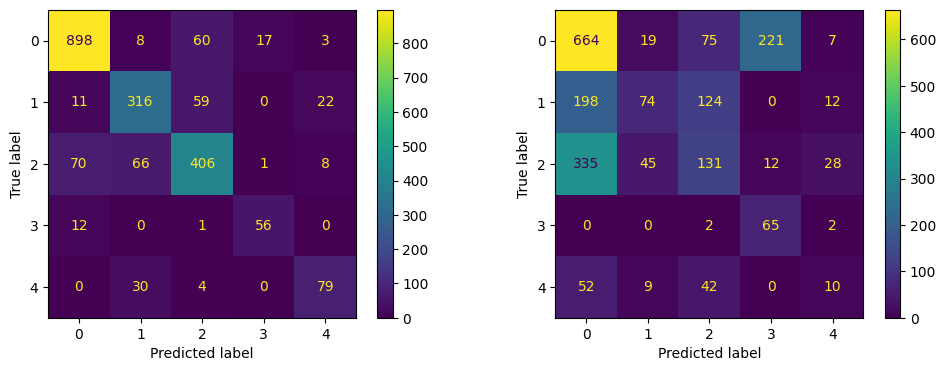

In [140]:
t = time()
dtc_preds = dtc.predict(X_test)
print(f"Decision Tree predict time (with PCA) = {time() - t:.3f}")
t=time()
nb_preds = nb.predict(X_test)
print(f"Naive Bayes predict time (with PCA) = {time() - t:.3f}")

#Compute MFCC
dtc_mfcc = matthews_corrcoef(y_test_class,dtc_preds)
nb_mfcc= matthews_corrcoef(y_test_class, nb_preds)

print(f"Decision Tree MFCC = {dtc_mfcc:.3f}", "\t"*5,  f"| Naive Bayes MFCC = {nb_mfcc:.3f}")

f, ax = plt.subplots(1,2, figsize=(12,4))
ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, dtc_preds)
).plot(ax=ax[0]);

ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, nb_preds)
).plot(ax=ax[1]);

Even with the independence of the variables, NB did not have a good performance. Has DT are universal function approximaters they performed better, as they can adapt more to every kind of relation with the data.

Comparing both decision trees, as with the regression, we see similar results on both datasets. Therefore, using the reduced dataset is advisable.